# Tarea 1 Métodos Numéricos {-}

### Integrantes {-}

- Juan Diego De la Rosa
- Juan Pablo González
- Isabella Gómez
- Cristian Cortez

In [14]:
# Librerías y configuración necesaria para el desarrollo

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import plotly.graph_objects as go

%matplotlib notebook

# Punto 1

# Punto 2

# Punto 3

# Punto 4

# Punto 5  {-}

En este punto se hace referencia al archivo `punto5.py` ubicado en este mismo directorio.

En primer lugar se cargan los archivos correspondientes a los puntos y las conexiones de los elementos, en el cual las medidas están en $\textrm{km}$.

In [15]:
pts = np.loadtxt('mallas/valle_aburra-quads.pts')/1000
quads = np.loadtxt('mallas/valle_aburra-quads.quad', dtype=np.int64)

### Gráficas

Con el objetivo de visualizar se grafican las curvas de nivel y la superficie tridimensional con ayuda de la librería matplotlib y el código suministrado en clase

<IPython.core.display.Javascript object>


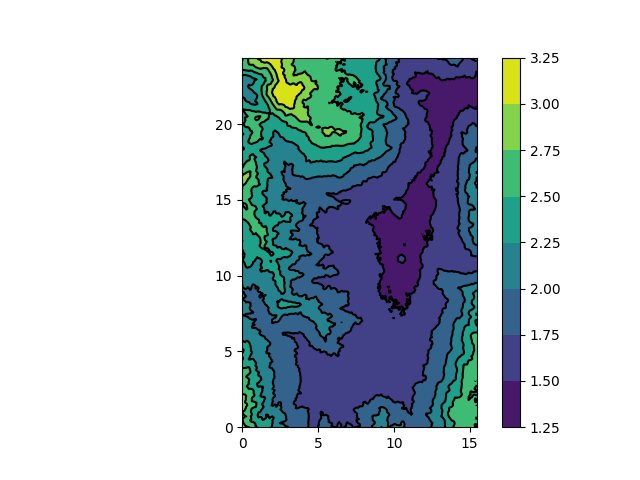

<IPython.core.display.Javascript object>


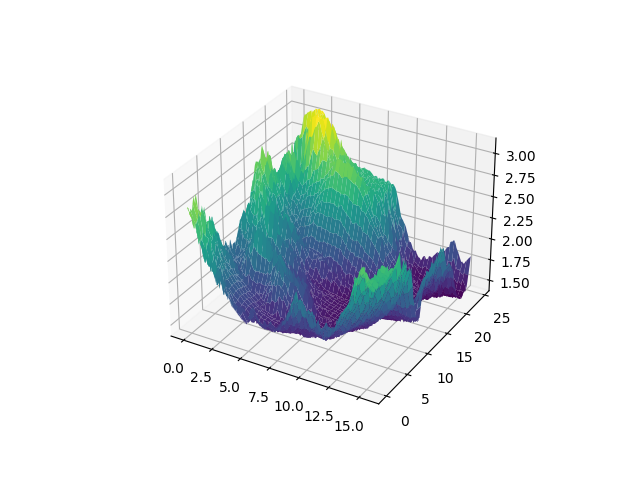

In [16]:
X = pts[:,0]
Y = pts[:,1]
Z = pts[:,2]

X.shape = 272, 173
Y.shape = 272, 173
Z.shape = 272, 173

graph = plt.contourf(X, Y, Z, cmap= 'viridis')
plt.contour(X, Y, Z, colors="black")
plt.axis("image")
plt.colorbar(graph)


fig = plt.figure()

ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis")

plt.show()

### Interpolación

Para esto es necesario analizar la forma como los elementos están dispuestos. Si se toma un elemento, tendrá la siguiente forma:

In [17]:
points = pts[quads[0]]
points

array([[ 0.   , 24.39 ,  2.519],
       [ 0.   , 24.3  ,  2.485],
       [ 0.09 , 24.3  ,  2.548],
       [ 0.09 , 24.39 ,  2.552]])

Donde se puede evidenciar que el la coordenada $x$ mínima se encuentra en el primer o segundo punto, y para el caso de la $y$ mínima, esta se encuentra en el segunto y tercero. Repitiendo el procedimiento se pudo observar que todos tienen este patrón y su base en $xy$ mide $0.09 \times 0.09\, \textrm{km}^3 $

Se puede graficar un elemento de la siguiente forma en matplotlib. Todas las $x$, $y$ y $z$ deben ser agrupadas en una matriz $2 \times 2$. Además, se tiene que invertir el orden de la segunda fila de esta, ya que se cumple la ley de la mano derecha y si no se tuviera esto en cuenta los elementos se unirían de forma cruzada. A continuación se muestra el primer elemento:

In [18]:
points

array([[ 0.   , 24.39 ,  2.519],
       [ 0.   , 24.3  ,  2.485],
       [ 0.09 , 24.3  ,  2.548],
       [ 0.09 , 24.39 ,  2.552]])

<IPython.core.display.Javascript object>


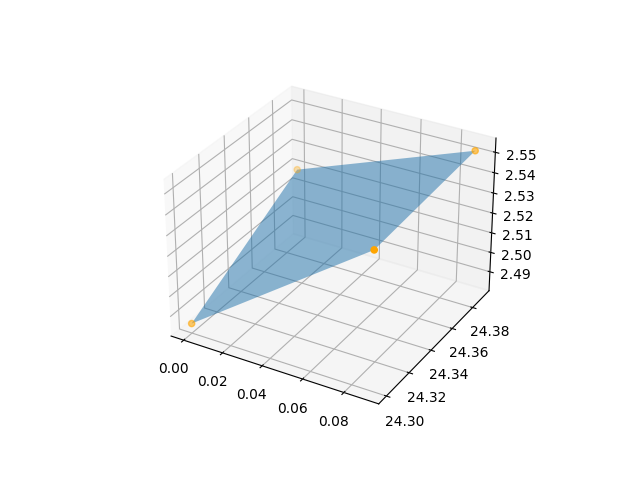

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.array([points[:2, 0], points[2:, 0][::-1]])
Y = np.array([points[:2, 1], points[2:, 1][::-1]])
Z = np.array([points[:2, 2], points[2:, 2][::-1]])

ax.plot_surface(X, Y, Z, alpha = 0.5)
ax.scatter(*points.T, color = 'orange')

ax.zaxis.set_major_formatter('{x:.02f}')

plt.show()

Mencionado lo anterior, para interpolar cada dominio $\Omega$ de manera independiente es necesario llevarlos todos a una misma posición en $x$ y $y$ para que puedan compartir funciones base entre sí.  
El primer paso para ello es crear la función `translate` que aplica dos translaciones al elemento:

-  Lleva el punto más cercano a la posición $x = 0$, $y = 0$.
-  Le resta a la posición anterior la mitad del valor de los elementos, en otras palabras centrarlos con el eje que pasa por $x = 0$ y $y = 0$.

In [20]:
def translate_to_origin(points):
    points = pts[quads[0]]

    _min_x = points[:, 0].min()
    _min_y = points[:, 1].min()

    points[:, 0] = points[:, 0] - _min_x - 0.045
    points[:, 1] = points[:, 1] - _min_y - 0.045

    return points

Para realizar la interpolación es necesario encontrar funciones base que valgan $0$ en el el punto para el cual
son especificadas y $1$ en este último. Estas funciones base se encontraron en el documento de los contenidos del curso definidas para límites entre $[-1, 1]^2$, para este caso que se encuentran entre $[-0.09, 0.09]^2$ se hicieron las modificaciones escalares por lo cual se escriben de la siguiente manera:

$$ N_A = \frac{1}{4}\left(\frac{1}{0.045}\right)^2(0.045 - x)(0.045 + y)$$
$$ N_B = \frac{1}{4}\left(\frac{1}{0.045}\right)^2(0.045 - x)(0.045 - y)$$
$$ N_C = \frac{1}{4}\left(\frac{1}{0.045}\right)^2(0.045 + x)(0.045 - y)$$
$$ N_D = \frac{1}{4}\left(\frac{1}{0.045}\right)^2(0.045 + x)(0.045 + y)$$

Donde A, B, C y D son los puntos ubicados de la siguiente manera:

![Puntos de la interpolación](assets/puntos_elemento.png)

Por lo cual se define la función `interpolate` que retorna simbólicamente la combinación lineal de estas 4 funciones base multiplicadas por el valor respectivo de cada punto que recibe como parámetro.

In [21]:
def interpolate(points):

    x, y = sym.symbols('x y')

    NA = (1/4)*((1/0.045)**2)*(0.045 - x)*(0.045 + y)
    NB = (1/4)*((1/0.045)**2)*(0.045 - x)*(0.045 - y)
    NC = (1/4)*((1/0.045)**2)*(0.045 + x)*(0.045 - y)
    ND = (1/4)*((1/0.045)**2)*(0.045 + x)*(0.045 + y)

    return NA*points[0, 2] + NB*points[1, 2] + NC*points[2, 2] + ND*points[3, 2]

t_points = translate_to_origin(points)
fn = interpolate(points)

Se puede comprobar evaluando en más puntos de los que tenía definidos originalmente:

<IPython.core.display.Javascript object>


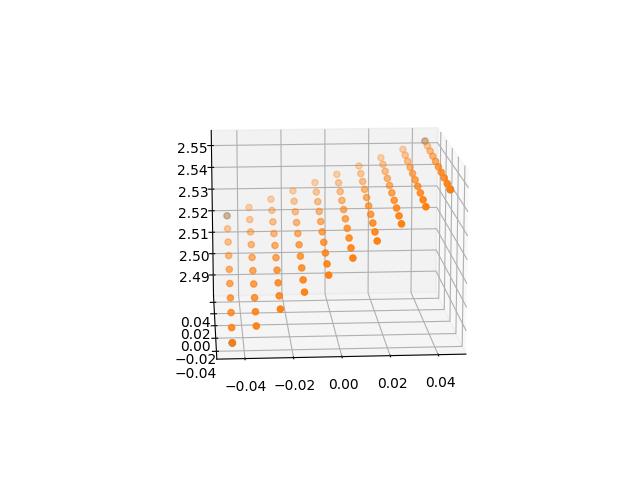

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_ = np.linspace(-0.045, 0.045, 10)
y_ = np.linspace(-0.045, 0.045, 10)

x_, y_ = np.meshgrid(x_, y_)

z = x_.copy()

for idx, it in np.ndenumerate(x_):
    z[idx] = fn.subs({'x': it, 'y': y_[idx]})


ax.scatter(t_points[:, 0], t_points[:, 1], t_points[:, 2])
ax.scatter(x_, y_, z)

plt.show()

### Cuadratura Gaussiana

Para aplicar la guadratura de [Gauss-Legendre](https://en.wikipedia.org/wiki/Gaussian_quadrature) con 3 puntos es necesariol hacer un cambio de los límites de integración mediante la fórmula:

$$\int_a^b f(x)\ dx \approx \frac{b - a}{2}\sum_{i = 1}^{n} f\left( \frac{b-a}{2}\xi + \frac{a+b}{2} \right)w_i$$

Dado que los puntos de prueba y los pesos para esta cuadratura están tabulados se eligirá en este ejemplo hacerlo con un n = 3 que es una excelente aproximación para funciones polinómicas de grados no tan altos.  
Para ello se tiene los puntos siguientes.

| puntos | pesos |
| :---: | :---: |
| 0 | $\frac{8}{9}$|
| $\pm\sqrt{\frac{3}{5}}$ | $\frac{5}{9}$ |

El área se calcula como una función que depende únicamente de las coordenadas en $z$.


In [23]:
x, y = sym.symbols('x y')

def compute_area(function):

    _lim = [-0.045, 0.045]
    _p_and_w = [[-np.sqrt(3/5), 5/9],[0, 8/9], [np.sqrt(3/5), 5/9]]

    _coef = (_lim[1] -_lim[0]) / 2

    var = lambda xi: (_coef*xi) + ((_lim[1] + _lim[0]) / 2)
    
    summ = 0

    for _y in _p_and_w:
        res = 0
        
        for _x in _p_and_w:
            
            res += function.subs({x: var(_x[0])})*_x[1]
        
        summ += res.subs({y: var(_y[0])})*_y[1]
        
    return _coef**2*summ


In [11]:
compute_area(fn)

0.0204606000000000

In [12]:
type(fn)

sympy.core.add.Add

Que es una aproximación muy buena, ya que la integral exacta, hecha en sympy resulta como:

In [13]:
sym.integrate(sym.integrate(fn, (x, -0.045, 0.045)), (y, -0.045, 0.045))

0.0204606000000000

En el archivo adjunto `punto5.py` se sigue este procedimiento pero iterando por todos los elementos, suya respuesta es: $199.4753\ \textrm{km}^3$

**Nota**: En el documento se hace un paso adicional para calcular el área que es restar a las coordenadas $z$ el $z_\textrm{mínimo}$ para medir el volumen con respecto al punto más bajo, esto se hace de la siguiente manera:

```python
pts[:, 2] = pts[:, 2] - pts[:, 2].min()
```

Salida de correr el código:

![Salida del código](assets/output_punto5.png)

# Punto 6